In [1]:
from enum import Enum, unique
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
@unique
class SEIR_State(Enum):
    """ Class representing the state of a person. """
    S = 1  # SUSCEPTIBLE
    E = 2  # EXPOSED
    I = 3  # INFECTIOUS
    R = 4  # RECOVERED

class Person:
    """  Class representing a person in the population, keeping track of 
    their state and the number of days (complete simulation steps) that the 
    person has been exposed or infected.
    
    Attributes:
        state: An SEIR_State indicating the state of the person
        days_spent_in_E: an integer number of days as exposed
        days_spent_in_I: an integer number of days as infectious
        max_days_in_E: an integer for the number of days that this person
                       stays in (E) before (I); defaults to 2 for everyone
        max_days_in_I: an integer for the number of days that this person
                       stays in (I) before (R); defaults to 14 for everyone
        testing_group: an integer specifying the testing group number
        last_contacts: list of integers corresponding to indices of contacts 
                       from the previous day
        in_quarantine: boolean of whether or not in quarantine
        days_in_quarantine: integer number of days spent in quarantine
        max_days_in_quarantine: an integer for the number of days that this
                                person stays in quarantine; defaults to 14 for everyone
    """
    def __init__(self, state):
        self.state = state
        self.days_spent_in_E = 0
        self.days_spent_in_I = 0
        self.max_days_in_E = 2
        self.max_days_in_I = 14
        self.testing_group = 0
        self.last_contacts = []
        self.in_quarantine = False
        self.days_in_quarantine = 0
        self.max_days_in_quarantine = 14
        
    def is_symptomatic(self):
        """ Boolean of whether or not this person is symptomatic. """
        return self.state == SEIR_State.I and self.days_spent_in_I > 3  
    
    def testing_today(self, d, t):
        """ Boolean of whether or not this person is testing on day t,
            given d testing groups. """
        return (self.testing_group - 1) % d == (t - 1) % d    

In [3]:
def initialize_person_list(N_S0, N_E0, N_I0, N_R0):
    """Form the initial state of the simulation.
    
    Args:
        N_S0: number of susceptible individuals
        N_E0: number of exposed individuals
        N_I0: number of infectious individuals
        N_R0: number of recovered individuals

    Returns:
        List of person objects of length equal 
        to the sum of N_S0, N_E0, N_I0, and N_R0.
    """
    
    plist = []

    for _ in range(N_S0):
        plist.append(Person(SEIR_State.S))

    for _ in range(N_E0):
        person = Person(SEIR_State.E)
        person.days_spent_in_E = np.random.choice(person.max_days_in_E - 1, 1)[0]
        plist.append(person)
        
    for _ in range(N_I0):
        person = Person(SEIR_State.I)
        person.days_spent_in_E = person.max_days_in_E
        person.days_spent_in_I = np.random.choice(person.max_days_in_I - 1, 1)[0]
        plist.append(person)
        
    for _ in range(N_R0):
        person = Person(SEIR_State.R)
        person.days_spent_in_E = person.max_days_in_E
        person.days_spent_in_E = person.max_days_in_I
        plist.append(person)
        
    return plist

In [4]:
def basic_SEIR_step(person_list, p, r, c):
    """Simulate one SEIR step.

    Args:
        person_list: list of person objects
        p: probability of contact transmission
        r: probability of infection from external source 
        c: number of others that one person comes into contact with
    """
    
    # Determine (S) people that become (E) at the end of this step.
    S_to_E = []
    
    # outside / external infections
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.S and not person.in_quarantine:
            if random.random() <= r:
                S_to_E.append(index)
                
    N = len(person_list)
    # internal infections
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.I and not person.in_quarantine:
            contacts = np.random.choice(N, c, replace=False)  # should also worry about whether index is sampled
            person.last_contacts = contacts  # keep track of contacts for tracing
            for contact in contacts:
                if person_list[contact].state == SEIR_State.S:
                    if not person_list[contact].in_quarantine:  # might be in quarantine from contact tracing
                        if random.random() <= p:
                            S_to_E.append(contact)
                              
    # Determine (E) people that become (I) at the end of this step.
    E_to_I = []
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.E:
            person.days_spent_in_E += 1
            if person.days_spent_in_E == person.max_days_in_E:
                E_to_I.append(index)    

    # Determine (I) people who become (R) at the end of this step.
    I_to_R = []
    for (index, person) in enumerate(person_list):
        if person.state == SEIR_State.I:
            person.days_spent_in_I += 1
            if person.days_spent_in_I == person.max_days_in_I:
                I_to_R.append(index)
                
    for person in person_list:
        if person.in_quarantine:
            person.days_in_quarantine += 1
        if person.days_in_quarantine == person.max_days_in_quarantine:
            # Someone quarantined from tracing can still be susceptible
            if person.state == SEIR_State.S:
                person.in_quarantine = False
                person.days_in_quarantine = 0

    # Update S --> E cases
    for index in S_to_E:
        person_list[index].state = SEIR_State.E

    # Update E --> I cases
    for index in E_to_I:
        person_list[index].state = SEIR_State.I

    # Update I --> R cases        
    for index in I_to_R:
        person_list[index].state = SEIR_State.R
        person_list[index].in_quarantine = False

### Self-reporting

Quarantining was a key way of reducing the number of contacts involving infectious individuals. To do this, though, we need to know who is sick. We first consider *self-reporting*. Someone who thinks they are sick may choose to quarantine themselves. However, one aspect of covid-19 is that infectiousness precedes symptoms. We will model this by saying that a person in the (I) state is asymptomatic for the first three days and symptomatic for the remaining 11. Each day that someone experience symptoms, there is some probability that they will self-report: $p_{\text{sr}} \equiv \text{Prob(a person self-reports on a given day $\;\vert\;$ they are experiencing symptoms)}$.
If an (I) person self-reports, they are quarantined until they reach the (R) state, and do not come into contact with anyone else.

Starting with your code from yesterday, implement self-reporting.

In [5]:
def self_reporting(person_list, p_sr):
    for person in person_list:
        if person.is_symptomatic() and random.random() <= p_sr:
            person.in_quarantine = True 
            
def run_testing_and_tracing(person_list, p_fn, d, t, run_tracing=False):
    positive_test_inds = []
    for (index, person) in enumerate(person_list):
        if person.testing_today(d, t):
            if person.state == SEIR_State.I and random.random() > p_fn:
                person.in_quarantine = True
                positive_test_inds.append(index)
    
    # If we are tracing, quarantine the contacts of those with positive tests
    if run_tracing:
        for index in positive_test_inds:
            for contact in person_list[index].last_contacts:
                person_list[contact].in_quarantine = True    

In [6]:
def run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T, 
                   p_sr=0.2, p_fn=0.1, d=7, 
                   run_self_reporting=False, run_testing=False, run_tracing=False):
    """Simulate T SEIR steps.
    
    Args:
        N_S0: number of susceptible individuals at initialization
        N_E0: number of exposed individuals at initialization
        N_I0: number of infectious individuals at initialization
        N_R0: number of recovered individuals at initialization  
        p: probability of contact transmission
        r: probability of infection from external source 
        c: number of others with whom an (I) person initiates contact
        T: number of time steps
        p_sr: self-reporting probability
        p_fn: false negative rate for tests
        d: number of testing groups (1/d days is testing frequency)
        run_self_reporting: include self-reporting in the simulation
        run_testing: include testing in the simulation
        run_tracing: include contact tracing in the simulation 
                     (won't run if run_testing is false)
    
    Returns:
        number of newly exposed individuals at each step
    """
    
    person_list = initialize_person_list(N_S0, N_E0, N_I0, N_R0)
    # Assign testing groups
    for (index, person) in enumerate(person_list):
        person.testing_group = (index % d) + 1  # 1, 2, ..., d
    
    # 0/1 array of who has ever been exposed
    has_been_exposed = [0 for _ in range(len(person_list))]
    for (index, person) in enumerate(person_list):
        if person.state in [SEIR_State.E, SEIR_State.I, SEIR_State.R]:
            has_been_exposed[index] = 1
    num_init_exposed = sum(has_been_exposed)
    
    num_exposed = [num_init_exposed]
    # Run simulation steps
    for t in range(1, T + 1):
        # Interventions at start of step
        if run_self_reporting: 
            self_reporting(person_list, p_sr)
        if run_testing:
            run_testing_and_tracing(person_list, p_fn, d, t, run_tracing)
            
        basic_SEIR_step(person_list, p, r, c)
        for (index, person) in enumerate(person_list):
            if person.state in [SEIR_State.E, SEIR_State.I, SEIR_State.R]:
                has_been_exposed[index] = 1
        num_exposed.append(sum(has_been_exposed))

    return [num_exposed[j] - num_exposed[j - 1] for j in range(1, T)]

Next, using some of the parameters from yesterday, make a plot that shows the number of newly exposed individuals at each time step for $T = 100$ time steps, for various values of $p_{\text{sr}}$. Also make a plot for the cumulative fraction of exposed individuals.

In [7]:
N_S0 = 970
N_E0 = 10
N_I0 = 10
N_R0 = 10
N = N_S0 + N_E0 + N_I0 + N_R0
p = 0.02
r = 0.001
c = 10
T = 100

Text(0, 0.5, 'Number of new (E)')

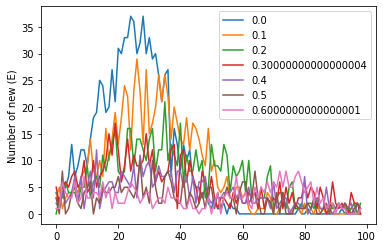

In [8]:
for new_p_sr in np.arange(0, 0.7, 0.1):
    newly_E = run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T, 
                             p_sr=new_p_sr, run_self_reporting=True)
    plt.plot(newly_E, label=new_p_sr)
plt.legend()
plt.ylabel("Number of new (E)")

### Testing

Testing has played a key role in identifying people with the virus. We will assume that the virus is not detectable in (E) people but is detectable in (I) people (both symptomatic and asymptomatic infectious people). However, testing requires medical resources and demands on time, so we cannot test everyone every day. Instead, we will assume that everyone gets tested just once in a span of $d$ days. Furthermore, each person is assigned randomly to one of $d$ testing groups. People in group 1 get their first test on day 1, people in group 2 get their first test on day 2, and so on. To keep things simple, we will assume that testing happens just after all self-reporting and that test results come back immediately.

Any (I) person that tests positive will be quarantined, making no physical contacts until they are recovered (R). The tests are not perfect, though&mdash;there are some false negatives. Specifically, we will model this with a probability $p_{\text{fn}} = \text{Prob(test is negative $\;\vert\;$ person is in (I) state)}$.

Implement the testing and quarantine policy. Use your parameters from above with $p_{\text{sr}} = 0.2$ and $p_{\text{fn}} = 0.1$. Plot the number of newly exposed individuals at each time step for various $d$, as well as the cumulative fraction of exposed individuals.

Text(0, 0.5, 'Cumulative fraction (E)')

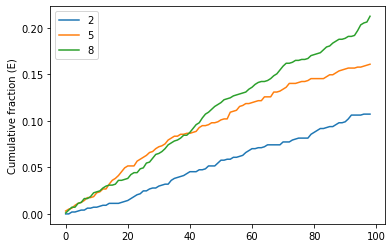

In [9]:
p_sr = 0.2
p_fn = 0.1

for new_d in np.arange(2, 9, 3):
    newly_E = run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T, 
                             d=new_d, p_sr=p_sr, p_fn=p_fn, run_self_reporting=True, run_testing=True)
    plt.plot(np.cumsum(newly_E) / N_S0, label=new_d)
plt.legend()
plt.ylabel("Cumulative fraction (E)")

### Contact tracing

If one person has the virus, then their past contacts are likely candidates for exposure. We will model an intervention strategy called *contact tracing*, where we quarantine the contacts of someone who tests positive. To do this, let's use the following simplified model. Let's say that each individual remembers the people with whom they initiated contact the previous day. If someone tests positive, then we immediately quarantine their contacts from the prior day for two weeks. These people could still be susceptible after quarantine if they were in the (S) state when quarantined.

Implement the contact tracing intervention. Set $14 \cdot cp = 2.5$, similar to yesterday. How much do the interventions decrease the spread of the virus?

Text(0, 0.5, 'Cumulative fraction (E)')

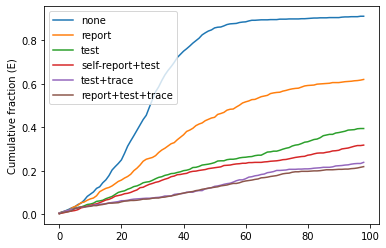

In [10]:
T = 100
p = 2.5 / 14 / c
r = 0.002
p_sr = 0.2
p_fn = 0.1

nothing = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T)) / N_S0

sr = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T,
                              p_sr=p_sr, run_self_reporting=True)) / N_S0
d = 7
test = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T,
                                d=d, p_sr=p_sr, p_fn=p_fn, 
                                run_testing=True)) / N_S0
sr_test = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T,
                                   d=d, p_sr=p_sr, p_fn=p_fn, 
                                   run_self_reporting=True, run_testing=True)) / N_S0


test_ct = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T,
                                   d=d, p_sr=p_sr, p_fn=p_fn, 
                                   run_testing=True, run_tracing=True)) / N_S0
sr_test_ct = np.cumsum(run_simulation(N_S0, N_E0, N_I0, N_R0, p, r, c, T,
                                      d=d, p_sr=p_sr, p_fn=p_fn, 
                                      run_self_reporting=True, run_testing=True, run_tracing=True)) / N_S0

plt.plot(nothing, label="none")
plt.plot(sr, label="report")
plt.plot(test, label="test")
plt.plot(sr_test, label="self-report+test")
plt.plot(test_ct, label="test+trace")
plt.plot(sr_test_ct, label="report+test+trace")
plt.legend()
plt.ylabel("Cumulative fraction (E)")